# NOCD

In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import normalize
%matplotlib inline

from utils import load_edgelist_graph,load_ordered_adjlist_graph
from evaluation import modularity, symmetric_matrix_modularity

torch.set_default_tensor_type(torch.cuda.FloatTensor)

## 1、Defining and training the model

Load the dataset
 - `A` (adjacency matrix) is a `scipy.sparse.csr_matrix` of size `[N, N]`
 - `X` (attribute matrix) is a `np.ndarray` of size `[N, D]`

In [2]:
name = 'bio72'

print('begin time:{}'.format(time.asctime(time.localtime(time.time()))))    
A = load_edgelist_graph(name)
X = np.loadtxt( './features/'+name+'.txt', dtype=float)
G_nx = load_ordered_adjlist_graph( './graphs/'+name+'.adjlist' )
N, D = X.shape
print('X shape:{} * {}'.format(N, D))

begin time:Sun Apr 25 17:11:19 2021
initial G nodes 25023,edges 968659
after G nodes 25023,edges 993682
X shape:25023 * 72


### Hyperparameters 

In [3]:
n_clusters = 8
hidden_sizes = [512]                  # hidden sizes of the GNN
weight_decay = 1e-2                   # strength of L2 regularization on GNN weights
dropout = 0.5                         # whether to use dropout
batch_norm = True                     # whether to use batch norm
lr = 1e-3                             # learning rate
max_epochs = 1000                     # number of epochs to train
display_step = 25                     # how often to compute validation loss
balance_loss = True                   # whether to use balanced loss
stochastic_loss = True                # whether to use stochastic or full-batch training
batch_size = 20000                    # batch size (only for stochastic training)

Select & normalize the feature matrix

For some datasets where the features are very informative / correlated with the community structure it's better to use `X` as input (e.g. co-authorship networks w/ keywords as node features). Otherwise, you should try using `A` or `[A, X]` as input.

In [4]:
cuda = torch.cuda.is_available()
device = torch.device( "cuda" if cuda else "cpu")
print("use cuda: {}".format( cuda))

x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = torch.Tensor(x_norm).cuda().to(torch.float32)

use cuda: True


Define the GNN model

In [5]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, n_clusters, batch_norm=batch_norm, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

Training loop

In [6]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

x_display_epochs, val_full_loss_list, x_train_epochs, train_loss_list = [],[],[],[]
for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % display_step == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
            x_display_epochs.append( epoch )
            val_full_loss_list.append( val_loss )
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f} ')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                stop_epoch = max_epochs
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    x_train_epochs.append( epoch )
    train_loss_list.append( loss )
    loss.backward()
    opt.step()
print(gnn)
print('train end time:{}'.format(time.asctime(time.localtime(time.time()))))  

Epoch    0, loss.full = 0.9747 
Epoch   25, loss.full = 0.5640 
Epoch   50, loss.full = 0.5153 
Epoch   75, loss.full = 0.4886 
Epoch  100, loss.full = 0.4857 
Epoch  125, loss.full = 0.4722 
Epoch  150, loss.full = 0.4670 
Epoch  175, loss.full = 0.4545 
Epoch  200, loss.full = 0.4467 
Epoch  225, loss.full = 0.4356 
Epoch  250, loss.full = 0.4268 
Epoch  275, loss.full = 0.4202 
Epoch  300, loss.full = 0.4198 
Epoch  325, loss.full = 0.4132 
Epoch  350, loss.full = 0.4112 
Epoch  375, loss.full = 0.4104 
Epoch  400, loss.full = 0.4104 
Epoch  425, loss.full = 0.4084 
Epoch  450, loss.full = 0.4086 
Epoch  475, loss.full = 0.4091 
Epoch  500, loss.full = 0.4076 
Epoch  525, loss.full = 0.4104 
Epoch  550, loss.full = 0.4069 
Epoch  575, loss.full = 0.4108 
Epoch  600, loss.full = 0.4071 
Epoch  625, loss.full = 0.4072 
Epoch  650, loss.full = 0.4059 
Epoch  675, loss.full = 0.4071 
Epoch  700, loss.full = 0.4094 
Epoch  725, loss.full = 0.4093 
Epoch  750, loss.full = 0.4076 
Epoch  7

## 2、Analyzing the results

Depending on whether you use balanced loss or not, you should (probably) use different threshold values. From my experience, following are reasonable defaults:
 - for `balance_loss = True`: `thresh = 0.5`
 - for `balance_loss = False`: `thresh = 0.01`
 
You can look at the distribution of the non-zero entries of `Z` to decide on a good value for the threshold. 
I guess it makes sense to select a value that lies in the leftmost "valley" of histogram below. 
You can also look at the unsupervised metrics in the next section of this notebook to make an informed choice.

Note that all of these are just speculations based on the behavior that I observed for a handful of datasets, YMMV.

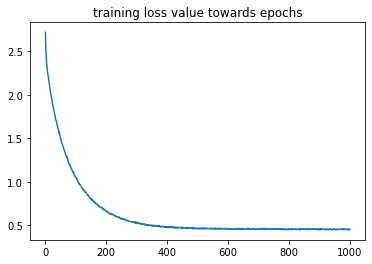

In [7]:
# 损失函数随迭代次数变化
plt.plot(x_train_epochs, train_loss_list, label='train_loss_list')
plt.title('training loss value towards epochs')
plt.show()

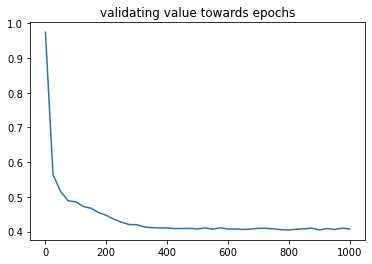

In [8]:
plt.title('validating value towards epochs')
plt.plot(x_display_epochs, val_full_loss_list, label='val_full_loss_list')
plt.show()

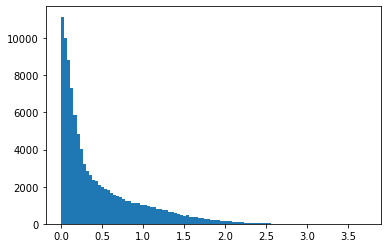

In [9]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

### Visualize the adjacency matrix sorted by the communities

In [10]:
Z_pred = F.relu(gnn(x_norm, adj_norm))
# Z_pred = Z.cpu().detach().numpy() > thresh 
Z_pred = np.argmax(Z_pred.cpu().detach().numpy(), 1)
model_saver.restore()

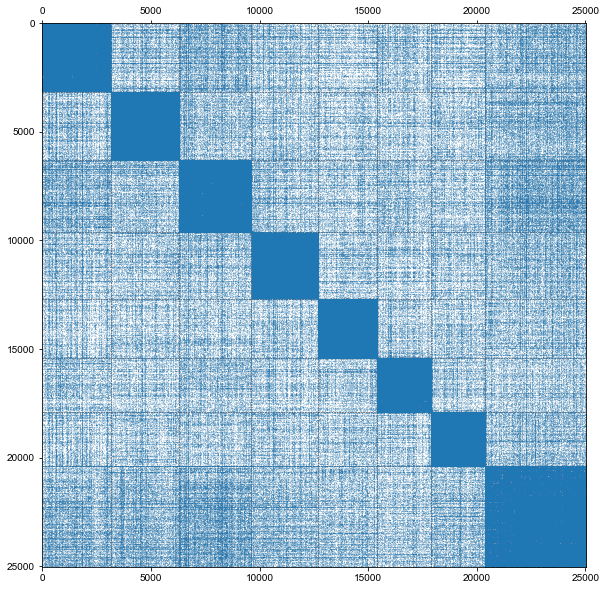

In [11]:
plt.figure(figsize=[10, 10])
# Z_pred = F.relu(gnn(x_norm, adj_norm)).cpu().detach().numpy()
# z = np.argmax(Z_pred, 1)
o = np.argsort(Z_pred)
nocd.utils.plot_sparse_clustered_adjacency(A, n_clusters, Z_pred, o, markersize=0.05)

In [12]:
print(f'\nFinal symmetric_matrix_modularity = {symmetric_matrix_modularity(G_nx, Z_pred):.8f}')
print('evaluae modularity end time:{}'.format(time.asctime(time.localtime(time.time()))))    

number of edges:993682.0
i:233,node_i:233
modularity running node:25022,now 2*m*modularity:497780.02783698
Final symmetric_matrix_modularity = 0.50095575
evaluae modularity end time:Sun Apr 25 17:20:37 2021


In [13]:
# Sizes of detected communities
print(Z_pred.sum(0))

89745


### Quantify quality of the communities based on unsupervised metrics.

Metrics:
* **Coverage**: what percentage of the edges is explained by at least one community? (i.e. if $(u, v)$ is an edge, both nodes share at least one community) Higher is better.
$$\textrm{Coverage}(C_1, ..., C_K) = \frac{1}{|E|}\sum_{u, v \in E} \mathbb{1}[z_u^T z_v > 0]$$


* **Density**: average density of the detected communities (weighted by community size). Higher is better.

$$\rho(C) = \frac{\text{# existing edges in $C$}}{\text{# of possible edges in $C$}}$$

$$\textrm{AvgDensity}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \rho(C_i) \cdot |C_i|$$


* **Conductance**: average conductance of the detected communities (weighted by community size). Lower is better.

$$\textrm{outside}(C) = \sum_{u \in C, v \notin C} A_{uv}$$

$$\textrm{inside}(C) = \sum_{u \in C, v \in C, v \ne u} A_{uv}$$

$$\textrm{Conductance}(C) = \frac{\textrm{outside}(C)}{\textrm{inside}(C) + \textrm{outside}(C)}$$

$$\textrm{AvgConductance}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{Conductance}(C_i) \cdot |C_i|$$


* **Clustering coefficient**: average clustering coefficient of the detected communities (weighted by community size). Higher is better.

$$\textrm{ClustCoef}(C) = \frac{\text{# existing triangles in $C$}}{\text{# of possible triangles in $C$}}$$

$$\textrm{AvgClustCoef}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{ClustCoef}(C_i) \cdot |C_i|$$

Clustering coefficient & density of the entire graph

In [14]:
density_baseline = A.nnz / (N**2 - N)
num_triangles = (A @ A @ A).diagonal().sum() / 6
num_possible_triangles = (N - 2) * (N - 1) * N / 6
clust_coef_baseline = num_triangles / num_possible_triangles
print(f'Background (over the entire graph):\n'
      f' - density    = {density_baseline:.3e}\n'
      f' - clust_coef = {clust_coef_baseline:.3e}')

Background (over the entire graph):
 - density    = 3.134e-03
 - clust_coef = 2.530e-12


### Ground truth communities & Predicted communities
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")
The detected partition has lower conductance / higher density / higher clustering coefficient than the GT communities.